<a href="https://colab.research.google.com/github/acmilannesta/Bert-embedding/blob/master/CDC/CDC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Link with github project folder

In [1]:
!git clone https://github.com/acmilannesta/Bert-embedding

Cloning into 'Bert-embedding'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 91 (delta 39), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (91/91), done.


In [0]:
import json
import numpy as np
import pandas as pd
from random import choice
import re, os, gc
import codecs
from keras.layers import *
from keras.models import Model
import keras.backend as K
from keras.optimizers import Adam, SGD
from keras.utils import to_categorical
from keras.callbacks import Callback, LearningRateScheduler
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

## Load Dataset
1. Add event weight
2. Reassin event code (0-47) for all


In [0]:
train = pd.read_csv('Bert-embedding/CDC/train.csv')
test = pd.read_csv('Bert-embedding/CDC/test.csv')
wt = pd.DataFrame(train.event.value_counts()/len(train)).rename(columns={'event':'weight'})
wt['event'] = wt.index
train = train.merge(wt, how='left', on='event')
train['event_idx'] = train.event.map({y:x for x, y in enumerate(np.sort(train.event.unique()))})
# X_train, X_val, y_train, y_val = train_test_split(train[['text', 'weight']], train['event'], test_size=0.2, random_state=0)
# train_data = list(zip(X_train['text'], X_train['weight'], y_train))
# valid_data = list(zip(X_val['text'], X_val['weight'], y_val))


## EDA: Word frequencies by Event Type

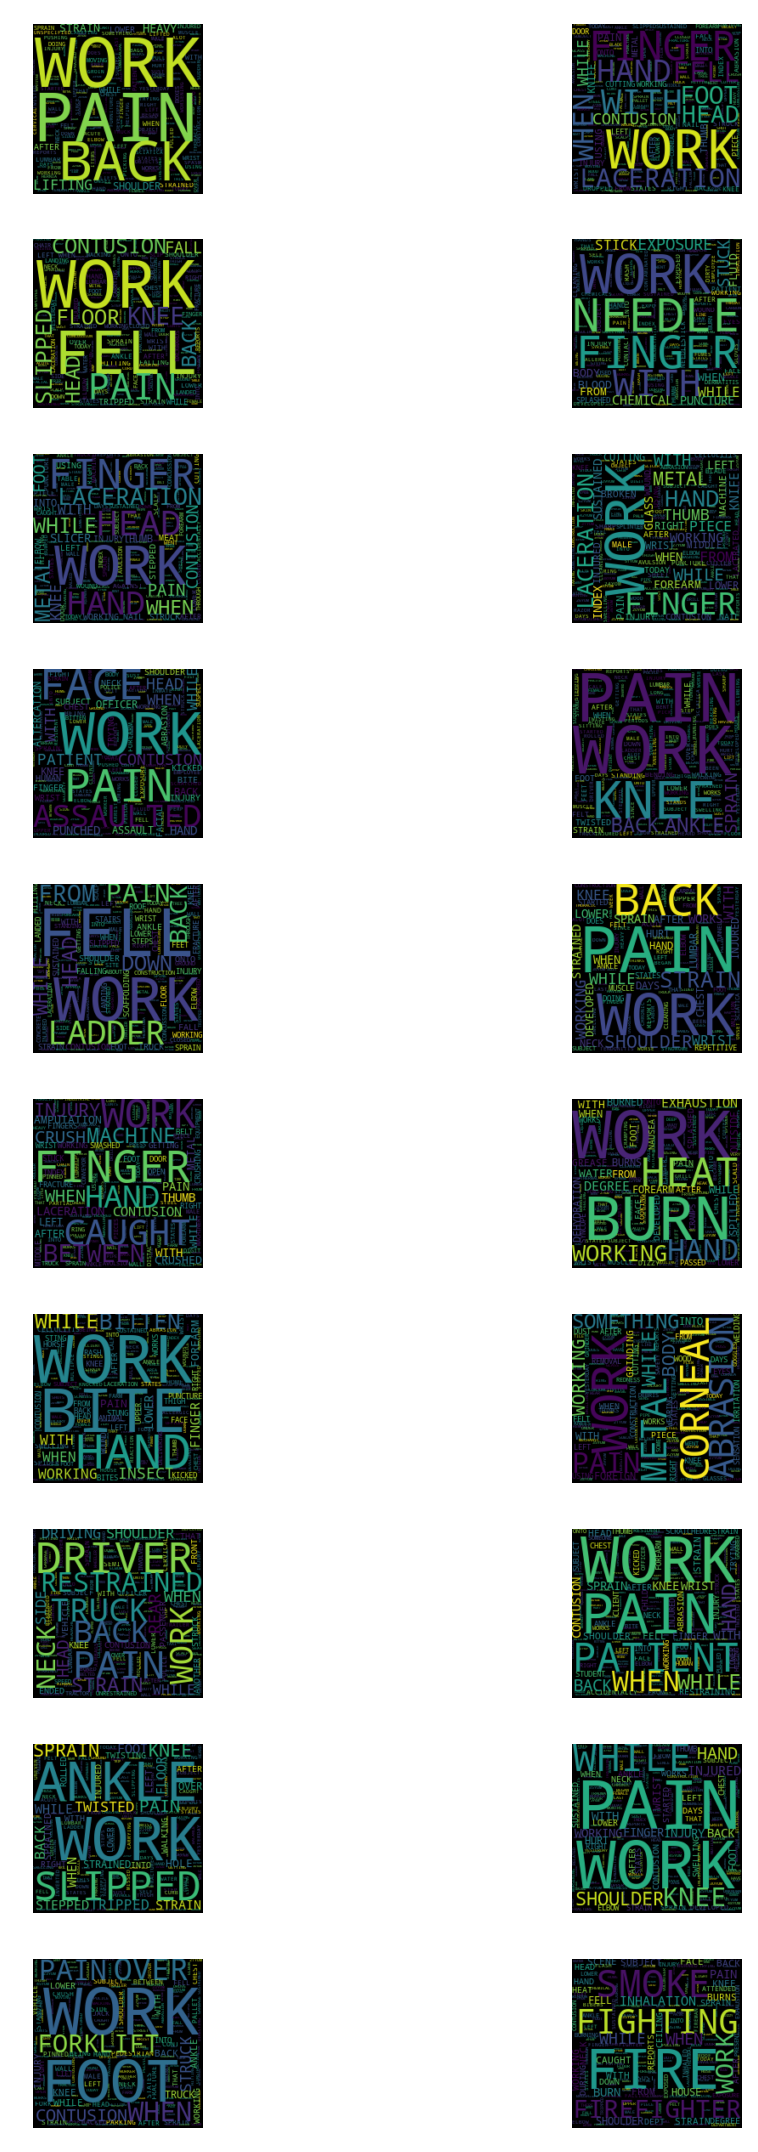

In [0]:
# Worclouds for top 20 events 
from itertools import groupby 
from wordcloud import WordCloud
import matplotlib.pyplot as plt
train['text_grouped'] = train.groupby('event')['text'].transform(lambda x: ' '.join(x))
x = train[['event', 'text_grouped', 'weight']].drop_duplicates('event').sort_values('weight', ascending=False)
x.reset_index(drop=True, inplace=True)

f, ax = plt.subplots(10, 2, figsize=(30,30))

for seq in range(20):
    string = x.loc[seq, 'text_grouped'].split(' ')
    counts = [(len(list(c)),i) for i,c in groupby(sorted(string)) if len(i)>3] 
    counts_dict = {x[1]:x[0] for x in counts}

    wordcloud = WordCloud(height=200, width=200, margin=0, collocations=False).generate_from_frequencies(counts_dict)
    
    ax[seq//2, seq%2].imshow(wordcloud, interpolation='bilinear')
    ax[seq//2, seq%2].set_title('event:'+str(x.loc[seq, 'event'])#+' weight:'+str(round(x.loc[seq, 'weight'], 2)),
                    ,fontsize=16, color='white')
    ax[seq//2, seq%2].set_axis_off()
    ax[seq//2, seq%2].margins(x=0, y=0)
    plt.tight_layout(w_pad=0.025)


# BERT

In [17]:
!pip install keras_bert
from keras_bert import load_trained_model_from_checkpoint, Tokenizer, AdamWarmup, calc_train_steps

## Download BERT checkpoint and dictionary

In [0]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!unzip uncased_L-12_H-768_A-12.zip

--2019-10-18 23:24:59--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 2607:f8b0:4001:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M  75.9MB/s    in 5.1s    

2019-10-18 23:25:09 (75.9 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


## Parameter setting

In [0]:
MAXLEN = 142 #@param {type:'slider', min:50, max:300, step:1}
BATCH_SIZE = 16 #@param {type:'slider', min:8, max:32, step:8}
config_path = 'uncased_L-12_H-768_A-12/bert_config.json' #@param ['uncased_L-12_H-768_A-12/bert_config.json', 'drive/My Drive/biobert_pretrain_output_all_notes_150000/bert_config.json']
checkpoint_path = 'uncased_L-12_H-768_A-12/bert_model.ckpt' #@param ['uncased_L-12_H-768_A-12/bert_model.ckpt', '/drive/My Drive/biobert_pretrain_output_all_notes_150000/model.ckpt']
dict_path = 'uncased_L-12_H-768_A-12/vocab.txt' #@param ['uncased_L-12_H-768_A-12/vocab.txt', 'drive/My Drive/biobert_pretrain_output_all_notes_150000/vocab.txt']

## Tokenize train and validation set

In [0]:
token_dict = {}
with codecs.open(dict_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        token_dict[token] = len(token_dict)
tokenizer = Tokenizer(token_dict)

In [0]:
def convert_data(data_df):
    data_df.reset_index(drop=True, inplace=True)
    global tokenizer
    indices, targets, weights = [], [], []
    for i in tqdm(range(len(data_df))):
        ids, segments = tokenizer.encode(data_df.loc[i, 'text'])
        indices.append(ids)
        targets.append(data_df.loc[i, 'event_idx'])
        weights.append(data_df.loc[i, 'weight'])
    items = list(zip(indices, targets, weights))
    np.random.shuffle(items)
    indices, targets, weights = zip(*items)
    return indices, np.array(targets), np.array(weights)

tr, val = train_test_split(train, test_size=0.2, random_state=0)
tr_x, tr_y, tr_wt = convert_data(tr)
val_x, val_y, val_wt = convert_data(val)

100%|██████████| 30792/30792 [00:07<00:00, 3858.78it/s]


## Data Generator

In [0]:
def seq_padding(X, padding=0):
    L = [len(x) for x in X]
    ML = max(L)
    return np.array([np.concatenate([x, [padding] * (ML - len(x))]) if len(x) < ML else x for x in X])

class data_generator:
    def __init__(self, data, batch_size=BATCH_SIZE, maxlen=MAXLEN):
        self.data = data
        self.batch_size = batch_size
        self.maxlen = maxlen
        self.steps = len(self.data) // self.batch_size
        if len(self.data) % self.batch_size != 0:
            self.steps += 1

    def __len__(self):
        return self.steps

    def __iter__(self):
        while True:
            for i in range(self.steps):
                d = self.data[i * self.batch_size: (i + 1) * self.batch_size]
                X1 = seq_padding([x[0] for x in d])
                Y = np.array([x[1] for x in d])
                W = np.array([x[2] for x in d])
                X2 = np.zeros_like(X1)
                yield [X1, X2, W], Y

##Model Assemble

In [0]:
bert_model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    seq_len = MAXLEN,
    trainable=True)

x1_in = Input(shape=(None,))
x2_in = Input(shape=(None,))
w_in = Input(shape=(1,))
inputs = bert_model([x1_in, x2_in])
# inputs = bert_model.inputs[:2]
# inputs.append(w_in)
# dense = bert_model.layers[-3].output
# x = bert_model([x1_in, x2_in])
dense = Lambda(lambda x: x[:, 0])(inputs)
outputs = Dense(48, activation='softmax')(dense)
model = Model([x1_in, x2_in, w_in], outputs)

# model = Model([x1_in, x2_in], p)

# def f1(weights):
#     def metric(y_true, y_pred):
#         true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))*weights)
#         possible_positives = K.sum(K.round(K.clip(y_true, 0, 1))*weights)
#         predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1))*weights)
#         precision = true_positives / (predicted_positives + K.epsilon())
#         recall = true_positives / (possible_positives + K.epsilon())
#         f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
#         return f1_val
#     return metric

decay_steps, warmup_steps = calc_train_steps(
    len(tr_x),
    batch_size=BATCH_SIZE,
    epochs=2,
)

model.compile(
    loss='sparse_categorical_crossentropy',
    # optimizer=SGD(lr=1e-4), #Adam(1e-5),
    optimizer=AdamWarmup(decay_steps=decay_steps, warmup_steps=warmup_steps, min_lr=1e-5, lr=1e-3),
    metrics= ['sparse_categorical_accuracy']
)


## Batchwise evaluation callback

In [0]:
class IntervalEvaluation(Callback):
    def __init__(self, validation_data, label, weight, interval=3000):
        # super(Callback, self).__init__()
        self.seen = 0
        self.interval = interval
        self.validation_data = validation_data
        self.label = label
        self.weight = weight
    def on_batch_end(self, batch, logs={}):
        self.seen += logs.get('num_steps', 1)
        if self.seen % self.interval == 0:
            y_pred = self.model.predict_generator(self.validation_data.__iter__(), len(self.validation_data))
            score = f1_score(self.label, np.argmax(y_pred, 1), average='weighted', sample_weight=self.weight)
            print(" - interval evaluation - batch: {:d} - score: {:.4f}".format(self.seen, score))

In [0]:
train_D = data_generator(list(zip(tr_x, tr_y, tr_wt)))
valid_D = data_generator(list(zip(val_x, val_y, val_wt)))
ival = IntervalEvaluation(validation_data=valid_D, label=val_y, weight=val_wt, interval = len(train_D))
model.fit_generator(
    train_D.__iter__(),
    steps_per_epoch=len(train_D),
    epochs=1,
    # validation_data=valid_D.__iter__(),
    # validation_steps=len(valid_D),
    callbacks = [ival]
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/2
7698/7698 [==============================] - 3114s 404ms/step - loss: 0.7412 - sparse_categorical_accuracy: 0.7844
Epoch 2/2
7698/7698 [==============================] - 3238s 421ms/step - loss: 0.3577 - sparse_categorical_accuracy: 0.8834


In [0]:
model.save('drive/My Drive/Bert_base.h5')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Prediction on test set

In [0]:
test_indices = []
for i in tqdm(range(len(test))):
    ids, segments = tokenizer.encode(test.loc[i, 'text'])
    test_indices.append(ids)

class test_generator:
    def __init__(self, data, batch_size=BATCH_SIZE, maxlen=MAXLEN):
        self.data = data
        self.batch_size = batch_size
        self.maxlen = maxlen
        self.steps = len(self.data) // self.batch_size
        if len(self.data) % self.batch_size != 0:
            self.steps += 1

    def __len__(self):
        return self.steps

    def __iter__(self):
        while True:
            for i in range(self.steps):
                d = self.data[i * self.batch_size: (i + 1) * self.batch_size]
                X1 = seq_padding(d)
                X2 = np.zeros_like(X1)
                W = np.ones(len(X1))
                yield [X1, X2, W]

100%|██████████| 75864/75864 [00:17<00:00, 4224.87it/s]


In [0]:
test_D = test_generator(test_indices)
pred = model.predict_generator(test_D.__iter__(), len(test_D), verbose=1)
test['event'] = np.argmax(pred, 1)
test['event'] = test.event.map({x:y for x, y in enumerate(np.sort(train.event.unique()))})

In [0]:
test.to_csv('solution.csv', index=False)

# xlnet

In [4]:
!wget https://storage.googleapis.com/xlnet/released_models/cased_L-12_H-768_A-12.zip
!unzip cased_L-12_H-768_A-12.zip

--2019-10-19 20:09:56--  https://storage.googleapis.com/xlnet/released_models/cased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.69.128, 2607:f8b0:4001:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 433638019 (414M) [application/zip]
Saving to: ‘cased_L-12_H-768_A-12.zip’

cased_L-12_H-768_A- 100%[===================>] 413.55M   114MB/s    in 3.6s    

2019-10-19 20:10:00 (114 MB/s) - ‘cased_L-12_H-768_A-12.zip’ saved [433638019/433638019]

Archive:  cased_L-12_H-768_A-12.zip
   creating: xlnet_cased_L-12_H-768_A-12/
  inflating: xlnet_cased_L-12_H-768_A-12/xlnet_model.ckpt.index  
  inflating: xlnet_cased_L-12_H-768_A-12/xlnet_model.ckpt.data-00000-of-00001  
  inflating: xlnet_cased_L-12_H-768_A-12/spiece.model  
  inflating: xlnet_cased_L-12_H-768_A-12/xlnet_model.ckpt.meta  
  inflating: xlnet_cased_L-12_H-768_A-12/xlnet_config.js

In [0]:
!pip install keras_xlnet

## Parameter Setting

In [3]:
import os
from keras_xlnet import Tokenizer, load_trained_model_from_checkpoint, ATTENTION_TYPE_BI, ATTENTION_TYPE_UNI

checkpoint_path = 'xlnet_cased_L-12_H-768_A-12'
MEMLEN=512
BATCH_SIZE=16

Using TensorFlow backend.


## Tokenize train and validation set

In [14]:
tokenizer = Tokenizer(os.path.join(checkpoint_path, 'spiece.model'))
def convert_data(data_df):
    data_df.reset_index(drop=True, inplace=True)
    global tokenizer
    indices, targets, weights = [], [], []
    for i in tqdm(range(len(data_df))):
        ids = tokenizer.encode(data_df.loc[i, 'text'])
        ids.extend([tokenizer.SYM_SEP, tokenizer.SYM_CLS])
        indices.append(ids)
        targets.append(data_df.loc[i, 'event_idx'])
        weights.append(data_df.loc[i, 'weight'])
    items = list(zip(indices, targets, weights))
    np.random.shuffle(items)
    indices, targets, weights = zip(*items)
    return indices, np.array(targets), np.array(weights)

tr, val = train_test_split(train, test_size=0.2, random_state=0)
tr_x, tr_y, tr_wt = convert_data(tr)
val_x, val_y, val_wt = convert_data(val)

100%|██████████| 30792/30792 [00:04<00:00, 6298.37it/s]


In [0]:
tr_x[0]

## Data generator

In [0]:
def seq_padding(X, padding=0):
  L = [len(x) for x in X]
  ML = max(L)
  return np.array([np.concatenate([x, [padding] * (ML - len(x))]) if len(x) < ML else x for x in X])

def seq_seg(X):
  seg = [[tokenizer.SYM_UNK]*(len(x)-1)+[tokenizer.SYM_EOS] for x in X]
  ML = max([len(x) for x in X])    
  return np.array([np.concatenate([x, [tokenizer.SYM_SEP] * (ML - len(x))]) if len(x) < ML else x for x in seg])

def seq_mask(X):
  mask = [[tokenizer.SYM_UNK]*len(x) for x in X]
  ML = max([len(x) for x in X])    
  return np.array([np.concatenate([x, [tokenizer.SYM_BOS] * (ML - len(x))]) if len(x) < ML else x for x in mask])


class data_generator:
  def __init__(self, data, batch_size=BATCH_SIZE, memlen=MEMLEN):
    self.data = data
    self.batch_size = batch_size
    self.memlen = memlen
    self.steps = len(self.data) // self.batch_size
    if len(self.data) % self.batch_size != 0:
        self.steps += 1
  def __len__(self):
    return self.steps
  def __iter__(self):
    while True:
        for i in range(self.steps):
            d = self.data[i * self.batch_size: (i + 1) * self.batch_size]
            X1 = seq_padding([x[0] for x in d])
            # segments
            X2 = seq_seg(([x[0] for x in d]))
            # memories
            X3 = np.array([self.memlen for i in range(len(d))])
            # masks
            # X4 = seq_mask(([x[0] for x in d]))
            Y = np.array([x[1] for x in d])
            yield [X1, X2, X3], Y

In [0]:
a = seq_padding(tr_x[:16])

## Model Assemble

In [16]:
xlnet_model = load_trained_model_from_checkpoint(
    config_path=os.path.join(checkpoint_path, 'xlnet_config.json'),
    checkpoint_path=os.path.join(checkpoint_path, 'xlnet_model.ckpt'),
    batch_size=BATCH_SIZE, #16
    memory_len=MEMLEN, #512
    target_len=142, #128
    in_train_phase=False,
    attention_type=ATTENTION_TYPE_BI,
)

In [19]:
x1_in = Input(shape=(None,))
x2_in = Input(shape=(None,))
x3_in = Input(shape=(1,))

x = xlnet_model([x1_in, x2_in, x3_in])
x = Lambda(lambda x: x[:, 0])(x)
p = Dense(48, activation='softmax')(x)

model = Model([x1_in, x2_in, x3_in], p)

decay_steps, warmup_steps = calc_train_steps(
    len(tr_x),
    batch_size=BATCH_SIZE,
    epochs=1,
)

model.compile(
    loss='sparse_categorical_crossentropy',
    # optimizer=SGD(lr=1e-4), #Adam(1e-5),
    optimizer=AdamWarmup(decay_steps=decay_steps, warmup_steps=warmup_steps, learning_rate=1e-3, min_lr=1e-5),
    metrics= ['sparse_categorical_accuracy']
)


## Batchwise evaluation callback

In [0]:
class IntervalEvaluation(Callback):
    def __init__(self, validation_data, label, weight, interval=3000):
        # super(Callback, self).__init__()
        self.seen = 0
        self.interval = interval
        self.validation_data = validation_data
        self.label = label
        self.weight = weight
    def on_batch_end(self, batch, logs={}):
        self.seen += logs.get('num_steps', 1)
        if self.seen % self.interval == 0:
            y_pred = self.model.predict_generator(self.validation_data.__iter__(), len(self.validation_data))
            score = f1_score(self.label, np.argmax(y_pred, 1), average='weighted', sample_weight=self.weight)
            print(" - interval evaluation - batch: {:d} - score: {:.4f}".format(self.seen, score))

In [0]:
train_D = data_generator(list(zip(tr_x, tr_y)))
valid_D = data_generator(list(zip(val_x, val_y)))
ival = IntervalEvaluation(validation_data=valid_D, label=val_y, weight=val_wt, interval = 1000)
model.fit_generator(
    train_D.__iter__(),
    steps_per_epoch=len(train_D),
    epochs=1,
    # validation_data=valid_D.__iter__(),
    # validation_steps=len(valid_D),
    callbacks = [ival]
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/1
  49/7698 [..............................] - ETA: 4:13:07 - loss: 3.8183 - sparse_categorical_accuracy: 0.1505

In [33]:
del model
gc.collect()

277827